In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# 📦 Setup
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
from sklearn.model_selection import train_test_split  # ✅ Fixed import


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unlabeled_root = "/kaggle/input/leafdetection7/Niphad Grape Leaf Disease Dataset (NGLD) (2)/unlabel"
labeled_root = "/kaggle/input/leafdetection7/Niphad Grape Leaf Disease Dataset (NGLD) (2)/lebel/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset"

augment = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.5, 0.5, 0.5, 0.1),
    T.RandomGrayscale(p=0.2),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

fine_tune_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

# ========================
# Unlabeled Dataset
# ========================
class UnlabeledImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) 
                            for f in os.listdir(root_dir) 
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

class BYOLPairDataset(Dataset):
    def __init__(self, base_dataset, augment_fn):
        self.base_dataset = base_dataset
        self.augment_fn = augment_fn

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image = self.base_dataset[idx]
        return self.augment_fn(image), self.augment_fn(image)

In [4]:
# BYOL Model
# ========================
class MLPHead(nn.Module):
    def __init__(self, in_dim, hidden_dim=4096, out_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)

class BYOL(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.online_encoder = nn.Sequential(backbone, MLPHead(2048))
        self.target_encoder = nn.Sequential(backbone, MLPHead(2048))
        self.predictor = MLPHead(256, 4096, 256)
        for param_q, param_k in zip(self.online_encoder.parameters(), self.target_encoder.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

    def update_target(self, beta=0.99):
        for param_q, param_k in zip(self.online_encoder.parameters(), self.target_encoder.parameters()):
            param_k.data = beta * param_k.data + (1 - beta) * param_q.data

    def forward(self, x1, x2):
        q1 = self.predictor(self.online_encoder(x1))
        q2 = self.predictor(self.online_encoder(x2))
        with torch.no_grad():
            k1 = self.target_encoder(x2)
            k2 = self.target_encoder(x1)
        return q1, k1.detach(), q2, k2.detach()

def byol_loss(x, y):
    x = nn.functional.normalize(x, dim=-1)
    y = nn.functional.normalize(y, dim=-1)
    return 2 - 2 * (x * y).sum(dim=-1).mean()


In [5]:
# Prepare BYOL dataset and dataloader
base_unlabeled_dataset = UnlabeledImageDataset(unlabeled_root)
byol_dataset = BYOLPairDataset(base_unlabeled_dataset, augment_fn=augment)
byol_loader = DataLoader(byol_dataset, batch_size=64, shuffle=True)

# Initialize BYOL model
resnet = models.resnet50(pretrained=False)
resnet.fc = nn.Identity()
byol_model = BYOL(resnet).to(device)
optimizer = torch.optim.Adam(byol_model.parameters(), lr=3e-4)

# Training configuration
num_epochs = 50  # set to 1 for testing
train_losses = []

# Pretraining loop
for epoch in range(num_epochs):
    byol_model.train()
    total_loss = 0

    for x1, x2 in tqdm(byol_loader, desc=f"Pretraining Epoch {epoch+1}"):
        x1, x2 = x1.to(device), x2.to(device)
        q1, k1, q2, k2 = byol_model(x1, x2)

        loss = byol_loss(q1, k1) + byol_loss(q2, k2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        byol_model.update_target()

        total_loss += loss.item()

    avg_loss = total_loss / len(byol_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Pretraining Epoch 1: 100%|██████████| 43/43 [01:59<00:00,  2.77s/it]


Epoch [1/50] Loss: 1.6711


Pretraining Epoch 2: 100%|██████████| 43/43 [01:22<00:00,  1.93s/it]


Epoch [2/50] Loss: 1.4427


Pretraining Epoch 3: 100%|██████████| 43/43 [01:22<00:00,  1.91s/it]


Epoch [3/50] Loss: 1.2071


Pretraining Epoch 4: 100%|██████████| 43/43 [01:22<00:00,  1.91s/it]


Epoch [4/50] Loss: 1.0673


Pretraining Epoch 5: 100%|██████████| 43/43 [01:21<00:00,  1.90s/it]


Epoch [5/50] Loss: 0.9746


Pretraining Epoch 6: 100%|██████████| 43/43 [01:22<00:00,  1.92s/it]


Epoch [6/50] Loss: 0.9237


Pretraining Epoch 7: 100%|██████████| 43/43 [01:21<00:00,  1.90s/it]


Epoch [7/50] Loss: 0.8823


Pretraining Epoch 8: 100%|██████████| 43/43 [01:21<00:00,  1.90s/it]


Epoch [8/50] Loss: 0.8530


Pretraining Epoch 9: 100%|██████████| 43/43 [01:21<00:00,  1.91s/it]


Epoch [9/50] Loss: 0.7710


Pretraining Epoch 10: 100%|██████████| 43/43 [01:22<00:00,  1.91s/it]


Epoch [10/50] Loss: 0.6704


Pretraining Epoch 11: 100%|██████████| 43/43 [01:21<00:00,  1.89s/it]


Epoch [11/50] Loss: 0.6209


Pretraining Epoch 12: 100%|██████████| 43/43 [01:21<00:00,  1.90s/it]


Epoch [12/50] Loss: 0.5836


Pretraining Epoch 13: 100%|██████████| 43/43 [01:21<00:00,  1.89s/it]


Epoch [13/50] Loss: 0.5377


Pretraining Epoch 14: 100%|██████████| 43/43 [01:21<00:00,  1.90s/it]


Epoch [14/50] Loss: 0.4816


Pretraining Epoch 15: 100%|██████████| 43/43 [01:22<00:00,  1.91s/it]


Epoch [15/50] Loss: 0.4167


Pretraining Epoch 16: 100%|██████████| 43/43 [01:21<00:00,  1.89s/it]


Epoch [16/50] Loss: 0.3647


Pretraining Epoch 17: 100%|██████████| 43/43 [01:21<00:00,  1.89s/it]


Epoch [17/50] Loss: 0.3225


Pretraining Epoch 18: 100%|██████████| 43/43 [01:21<00:00,  1.91s/it]


Epoch [18/50] Loss: 0.3085


Pretraining Epoch 19: 100%|██████████| 43/43 [01:21<00:00,  1.90s/it]


Epoch [19/50] Loss: 0.2964


Pretraining Epoch 20: 100%|██████████| 43/43 [01:21<00:00,  1.91s/it]


Epoch [20/50] Loss: 0.2880


Pretraining Epoch 21: 100%|██████████| 43/43 [01:21<00:00,  1.90s/it]


Epoch [21/50] Loss: 0.3038


Pretraining Epoch 22: 100%|██████████| 43/43 [01:21<00:00,  1.91s/it]


Epoch [22/50] Loss: 0.3222


Pretraining Epoch 23: 100%|██████████| 43/43 [01:21<00:00,  1.90s/it]


Epoch [23/50] Loss: 0.3167


Pretraining Epoch 24: 100%|██████████| 43/43 [01:20<00:00,  1.88s/it]


Epoch [24/50] Loss: 0.3123


Pretraining Epoch 25: 100%|██████████| 43/43 [01:21<00:00,  1.89s/it]


Epoch [25/50] Loss: 0.3123


Pretraining Epoch 26: 100%|██████████| 43/43 [01:21<00:00,  1.89s/it]


Epoch [26/50] Loss: 0.3211


Pretraining Epoch 27: 100%|██████████| 43/43 [01:22<00:00,  1.93s/it]


Epoch [27/50] Loss: 0.3338


Pretraining Epoch 28: 100%|██████████| 43/43 [01:21<00:00,  1.89s/it]


Epoch [28/50] Loss: 0.3763


Pretraining Epoch 29: 100%|██████████| 43/43 [01:22<00:00,  1.93s/it]


Epoch [29/50] Loss: 0.3928


Pretraining Epoch 30: 100%|██████████| 43/43 [01:21<00:00,  1.90s/it]


Epoch [30/50] Loss: 0.3873


Pretraining Epoch 31: 100%|██████████| 43/43 [01:25<00:00,  1.98s/it]


Epoch [31/50] Loss: 0.4000


Pretraining Epoch 32: 100%|██████████| 43/43 [01:21<00:00,  1.90s/it]


Epoch [32/50] Loss: 0.4425


Pretraining Epoch 33: 100%|██████████| 43/43 [01:21<00:00,  1.89s/it]


Epoch [33/50] Loss: 0.5165


Pretraining Epoch 34: 100%|██████████| 43/43 [01:22<00:00,  1.92s/it]


Epoch [34/50] Loss: 0.6381


Pretraining Epoch 35: 100%|██████████| 43/43 [01:22<00:00,  1.91s/it]


Epoch [35/50] Loss: 0.8885


Pretraining Epoch 36: 100%|██████████| 43/43 [01:21<00:00,  1.90s/it]


Epoch [36/50] Loss: 0.9974


Pretraining Epoch 37: 100%|██████████| 43/43 [01:21<00:00,  1.89s/it]


Epoch [37/50] Loss: 0.9608


Pretraining Epoch 38: 100%|██████████| 43/43 [01:21<00:00,  1.89s/it]


Epoch [38/50] Loss: 0.9486


Pretraining Epoch 39: 100%|██████████| 43/43 [01:20<00:00,  1.88s/it]


Epoch [39/50] Loss: 0.8915


Pretraining Epoch 40: 100%|██████████| 43/43 [01:21<00:00,  1.89s/it]


Epoch [40/50] Loss: 0.8598


Pretraining Epoch 41: 100%|██████████| 43/43 [01:22<00:00,  1.92s/it]


Epoch [41/50] Loss: 0.8182


Pretraining Epoch 42: 100%|██████████| 43/43 [01:22<00:00,  1.93s/it]


Epoch [42/50] Loss: 0.7809


Pretraining Epoch 43: 100%|██████████| 43/43 [01:21<00:00,  1.89s/it]


Epoch [43/50] Loss: 0.7894


Pretraining Epoch 44: 100%|██████████| 43/43 [01:20<00:00,  1.88s/it]


Epoch [44/50] Loss: 0.8312


Pretraining Epoch 45: 100%|██████████| 43/43 [01:21<00:00,  1.88s/it]


Epoch [45/50] Loss: 0.8933


Pretraining Epoch 46: 100%|██████████| 43/43 [01:21<00:00,  1.89s/it]


Epoch [46/50] Loss: 0.8736


Pretraining Epoch 47: 100%|██████████| 43/43 [01:20<00:00,  1.88s/it]


Epoch [47/50] Loss: 0.8918


Pretraining Epoch 48: 100%|██████████| 43/43 [01:21<00:00,  1.89s/it]


Epoch [48/50] Loss: 0.8787


Pretraining Epoch 49: 100%|██████████| 43/43 [01:20<00:00,  1.88s/it]


Epoch [49/50] Loss: 0.8920


Pretraining Epoch 50: 100%|██████████| 43/43 [01:22<00:00,  1.91s/it]

Epoch [50/50] Loss: 0.8737


In [6]:
torch.save(byol_model.online_encoder[0].state_dict(), "byol_encoder.pth")
print("✅ BYOL pretrained encoder saved as 'byol_encoder.pth'")


✅ BYOL pretrained encoder saved as 'byol_encoder.pth'


In [7]:
import os

# List all files in current working directory
print("📁 Files in working directory:")
for file in os.listdir():
    print(" -", file)


📁 Files in working directory:
 - .virtual_documents
 - byol_encoder.pth


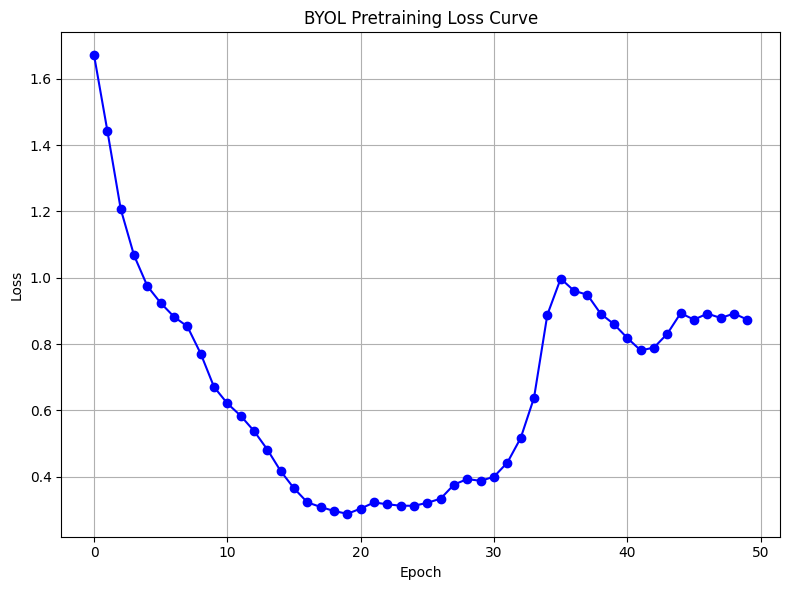

In [8]:
# Plot Loss Curve
# ========================
plt.figure(figsize=(8, 6))
plt.plot(train_losses, marker='o', color='blue')
plt.title("BYOL Pretraining Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.savefig("byol_pretrain_loss_curve.png", dpi=200)
plt.show()

In [18]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# -----------------------------
# Configuration
# -----------------------------
train_dir = "/kaggle/input/detestion6/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset train"
val_dir   = "/kaggle/input/detestion6/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset validate"
pretrained_path = "/kaggle/working/byol_encoder.pth"

num_epochs = 50
batch_size = 32
lr = 1e-4
image_size = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Transforms & Datasets
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset   = torchvision.datasets.ImageFolder(root=val_dir,   transform=transform)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

# -----------------------------
# BYOL ResNet Encoder
# -----------------------------
class BYOLResNet50(nn.Module):
    def __init__(self, pretrained_path):
        super(BYOLResNet50, self).__init__()
        resnet = torchvision.models.resnet50(pretrained=False)
        resnet.fc = nn.Identity()
        self.backbone = resnet
        state_dict = torch.load(pretrained_path, map_location='cpu')
        # strict=False to allow BYOL projector/predictor mismatches
        self.backbone.load_state_dict(state_dict, strict=False)

    def forward(self, x):
        return self.backbone(x)

# -----------------------------
# Fine-Tuning Model
# -----------------------------
class FineTuneBYOL(nn.Module):
    def __init__(self, encoder, num_classes):
        super(FineTuneBYOL, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

# Instantiate model
encoder = BYOLResNet50(pretrained_path)
model = FineTuneBYOL(encoder, num_classes).to(device)

# -----------------------------
# Training Setup
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# -----------------------------
# Training Loop
# -----------------------------
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_acc = correct_train / total_train
    train_accuracies.append(train_acc)

    # -------------------------
    # Validation
    # -------------------------
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss_sum = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_sum += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss_sum / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = correct_val / total_val
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")


Classes: ['Bacterial Leaf Spot', 'Downy Mildew', 'Healthy Leaves', 'Powdery Mildew']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/50: 100%|██████████| 60/60 [00:26<00:00,  2.26it/s, loss=0.746]


Epoch 1: Train Loss: 0.8317, Train Acc: 0.6855, Val Loss: 1.8414, Val Acc: 0.3007


Epoch 2/50: 100%|██████████| 60/60 [00:26<00:00,  2.31it/s, loss=0.565]


Epoch 2: Train Loss: 0.4598, Train Acc: 0.8328, Val Loss: 1.5601, Val Acc: 0.4279


Epoch 3/50: 100%|██████████| 60/60 [00:25<00:00,  2.35it/s, loss=0.138] 


Epoch 3: Train Loss: 0.3500, Train Acc: 0.8658, Val Loss: 0.7542, Val Acc: 0.7653


Epoch 4/50: 100%|██████████| 60/60 [00:26<00:00,  2.30it/s, loss=0.203]


Epoch 4: Train Loss: 0.2817, Train Acc: 0.8931, Val Loss: 0.6470, Val Acc: 0.7800


Epoch 5/50: 100%|██████████| 60/60 [00:26<00:00,  2.29it/s, loss=0.263] 


Epoch 5: Train Loss: 0.2360, Train Acc: 0.9193, Val Loss: 0.8783, Val Acc: 0.6748


Epoch 6/50: 100%|██████████| 60/60 [00:25<00:00,  2.33it/s, loss=0.24]  


Epoch 6: Train Loss: 0.2222, Train Acc: 0.9188, Val Loss: 1.7297, Val Acc: 0.5501


Epoch 7/50: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s, loss=0.438] 


Epoch 7: Train Loss: 0.1779, Train Acc: 0.9366, Val Loss: 0.8886, Val Acc: 0.6748


Epoch 8/50: 100%|██████████| 60/60 [00:26<00:00,  2.29it/s, loss=0.107] 


Epoch 8: Train Loss: 0.1757, Train Acc: 0.9376, Val Loss: 1.1940, Val Acc: 0.7164


Epoch 9/50: 100%|██████████| 60/60 [00:25<00:00,  2.31it/s, loss=0.0572]


Epoch 9: Train Loss: 0.1178, Train Acc: 0.9575, Val Loss: 0.9109, Val Acc: 0.7628


Epoch 10/50: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s, loss=0.233] 


Epoch 10: Train Loss: 0.0971, Train Acc: 0.9675, Val Loss: 0.9214, Val Acc: 0.7653


Epoch 11/50: 100%|██████████| 60/60 [00:25<00:00,  2.31it/s, loss=0.0603]


Epoch 11: Train Loss: 0.1306, Train Acc: 0.9560, Val Loss: 1.2189, Val Acc: 0.6186


Epoch 12/50: 100%|██████████| 60/60 [00:38<00:00,  1.55it/s, loss=0.0516] 


Epoch 12: Train Loss: 0.1093, Train Acc: 0.9665, Val Loss: 0.8802, Val Acc: 0.7775


Epoch 13/50: 100%|██████████| 60/60 [00:47<00:00,  1.26it/s, loss=0.0362] 


Epoch 13: Train Loss: 0.0655, Train Acc: 0.9769, Val Loss: 0.9369, Val Acc: 0.7971


Epoch 14/50: 100%|██████████| 60/60 [00:46<00:00,  1.29it/s, loss=0.00544]


Epoch 14: Train Loss: 0.0576, Train Acc: 0.9832, Val Loss: 0.4569, Val Acc: 0.8778


Epoch 15/50: 100%|██████████| 60/60 [00:43<00:00,  1.37it/s, loss=0.0498] 


Epoch 15: Train Loss: 0.0383, Train Acc: 0.9864, Val Loss: 0.3931, Val Acc: 0.8729


Epoch 16/50: 100%|██████████| 60/60 [00:40<00:00,  1.48it/s, loss=0.0755] 


Epoch 16: Train Loss: 0.0468, Train Acc: 0.9796, Val Loss: 0.4159, Val Acc: 0.8998


Epoch 17/50: 100%|██████████| 60/60 [00:44<00:00,  1.35it/s, loss=0.118] 


Epoch 17: Train Loss: 0.1422, Train Acc: 0.9575, Val Loss: 0.4259, Val Acc: 0.8826


Epoch 18/50: 100%|██████████| 60/60 [00:38<00:00,  1.56it/s, loss=0.0717] 


Epoch 18: Train Loss: 0.0657, Train Acc: 0.9811, Val Loss: 0.2885, Val Acc: 0.9267


Epoch 19/50: 100%|██████████| 60/60 [00:28<00:00,  2.07it/s, loss=0.00466]


Epoch 19: Train Loss: 0.0436, Train Acc: 0.9858, Val Loss: 0.3584, Val Acc: 0.9169


Epoch 20/50: 100%|██████████| 60/60 [00:26<00:00,  2.27it/s, loss=0.0673] 


Epoch 20: Train Loss: 0.0541, Train Acc: 0.9806, Val Loss: 0.4280, Val Acc: 0.8973


Epoch 21/50: 100%|██████████| 60/60 [00:26<00:00,  2.30it/s, loss=0.058]   


Epoch 21: Train Loss: 0.0168, Train Acc: 0.9963, Val Loss: 0.4697, Val Acc: 0.8998


Epoch 22/50: 100%|██████████| 60/60 [00:25<00:00,  2.31it/s, loss=0.019]   


Epoch 22: Train Loss: 0.0206, Train Acc: 0.9921, Val Loss: 0.1728, Val Acc: 0.9438


Epoch 23/50: 100%|██████████| 60/60 [00:26<00:00,  2.29it/s, loss=0.0155] 


Epoch 23: Train Loss: 0.0716, Train Acc: 0.9764, Val Loss: 1.1231, Val Acc: 0.7359


Epoch 24/50: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s, loss=0.00198]


Epoch 24: Train Loss: 0.0607, Train Acc: 0.9796, Val Loss: 0.4051, Val Acc: 0.9071


Epoch 25/50: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s, loss=0.00631]


Epoch 25: Train Loss: 0.0429, Train Acc: 0.9848, Val Loss: 0.9178, Val Acc: 0.8435


Epoch 26/50: 100%|██████████| 60/60 [00:25<00:00,  2.31it/s, loss=0.00303] 


Epoch 26: Train Loss: 0.0212, Train Acc: 0.9927, Val Loss: 0.7726, Val Acc: 0.8631


Epoch 27/50: 100%|██████████| 60/60 [00:26<00:00,  2.30it/s, loss=0.044]   


Epoch 27: Train Loss: 0.0117, Train Acc: 0.9974, Val Loss: 0.6463, Val Acc: 0.8533


Epoch 28/50: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s, loss=0.0033]  


Epoch 28: Train Loss: 0.0289, Train Acc: 0.9900, Val Loss: 0.4456, Val Acc: 0.9046


Epoch 29/50: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s, loss=0.000617]


Epoch 29: Train Loss: 0.0255, Train Acc: 0.9916, Val Loss: 0.2096, Val Acc: 0.9511


Epoch 30/50: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s, loss=0.0988] 


Epoch 30: Train Loss: 0.0421, Train Acc: 0.9838, Val Loss: 0.6912, Val Acc: 0.8264


Epoch 31/50: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s, loss=0.138]  


Epoch 31: Train Loss: 0.0503, Train Acc: 0.9838, Val Loss: 0.6920, Val Acc: 0.8509


Epoch 32/50: 100%|██████████| 60/60 [00:25<00:00,  2.33it/s, loss=0.0494]  


Epoch 32: Train Loss: 0.0368, Train Acc: 0.9864, Val Loss: 1.1320, Val Acc: 0.8166


Epoch 33/50: 100%|██████████| 60/60 [00:26<00:00,  2.29it/s, loss=0.00688] 


Epoch 33: Train Loss: 0.0582, Train Acc: 0.9811, Val Loss: 0.5209, Val Acc: 0.8704


Epoch 34/50: 100%|██████████| 60/60 [00:25<00:00,  2.31it/s, loss=0.013]   


Epoch 34: Train Loss: 0.0475, Train Acc: 0.9858, Val Loss: 0.7756, Val Acc: 0.8631


Epoch 35/50: 100%|██████████| 60/60 [00:26<00:00,  2.30it/s, loss=0.000989]


Epoch 35: Train Loss: 0.0125, Train Acc: 0.9953, Val Loss: 0.2972, Val Acc: 0.9218


Epoch 36/50: 100%|██████████| 60/60 [00:26<00:00,  2.29it/s, loss=0.00143] 


Epoch 36: Train Loss: 0.0079, Train Acc: 0.9963, Val Loss: 0.4326, Val Acc: 0.9022


Epoch 37/50: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s, loss=0.0233]  


Epoch 37: Train Loss: 0.0030, Train Acc: 1.0000, Val Loss: 0.4527, Val Acc: 0.9389


Epoch 38/50: 100%|██████████| 60/60 [00:26<00:00,  2.29it/s, loss=4.86e-5] 


Epoch 38: Train Loss: 0.0064, Train Acc: 0.9979, Val Loss: 0.5270, Val Acc: 0.8875


Epoch 39/50: 100%|██████████| 60/60 [00:26<00:00,  2.31it/s, loss=0.00147] 


Epoch 39: Train Loss: 0.0076, Train Acc: 0.9963, Val Loss: 0.6228, Val Acc: 0.8680


Epoch 40/50: 100%|██████████| 60/60 [00:26<00:00,  2.29it/s, loss=0.000497]


Epoch 40: Train Loss: 0.0086, Train Acc: 0.9979, Val Loss: 0.6147, Val Acc: 0.8851


Epoch 41/50: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s, loss=0.0149]  


Epoch 41: Train Loss: 0.0377, Train Acc: 0.9879, Val Loss: 0.6386, Val Acc: 0.8509


Epoch 42/50: 100%|██████████| 60/60 [00:26<00:00,  2.31it/s, loss=0.00691] 


Epoch 42: Train Loss: 0.0412, Train Acc: 0.9848, Val Loss: 1.5523, Val Acc: 0.7066


Epoch 43/50: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s, loss=0.0482]  


Epoch 43: Train Loss: 0.0383, Train Acc: 0.9874, Val Loss: 0.7678, Val Acc: 0.8582


Epoch 44/50: 100%|██████████| 60/60 [00:25<00:00,  2.31it/s, loss=0.00175] 


Epoch 44: Train Loss: 0.0363, Train Acc: 0.9895, Val Loss: 0.9574, Val Acc: 0.8240


Epoch 45/50: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s, loss=0.0456]  


Epoch 45: Train Loss: 0.0214, Train Acc: 0.9958, Val Loss: 0.5854, Val Acc: 0.8875


Epoch 46/50: 100%|██████████| 60/60 [00:25<00:00,  2.31it/s, loss=0.0137]  


Epoch 46: Train Loss: 0.0104, Train Acc: 0.9958, Val Loss: 0.9115, Val Acc: 0.8191


Epoch 47/50: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s, loss=0.000118]


Epoch 47: Train Loss: 0.0262, Train Acc: 0.9911, Val Loss: 0.3403, Val Acc: 0.9315


Epoch 48/50: 100%|██████████| 60/60 [00:26<00:00,  2.31it/s, loss=0.0529] 


Epoch 48: Train Loss: 0.0896, Train Acc: 0.9717, Val Loss: 0.5262, Val Acc: 0.8875


Epoch 49/50: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s, loss=0.146]   


Epoch 49: Train Loss: 0.0635, Train Acc: 0.9801, Val Loss: 0.6151, Val Acc: 0.8557


Epoch 50/50: 100%|██████████| 60/60 [00:26<00:00,  2.30it/s, loss=0.124]   


Epoch 50: Train Loss: 0.0375, Train Acc: 0.9900, Val Loss: 0.3015, Val Acc: 0.9315


In [19]:
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")

Validation Accuracy: 0.9315
Train Accuracy: 0.9900


In [20]:
# Save the full model state dict
model_path = "/kaggle/working/fine_tuned_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to /kaggle/working/fine_tuned_model.pth


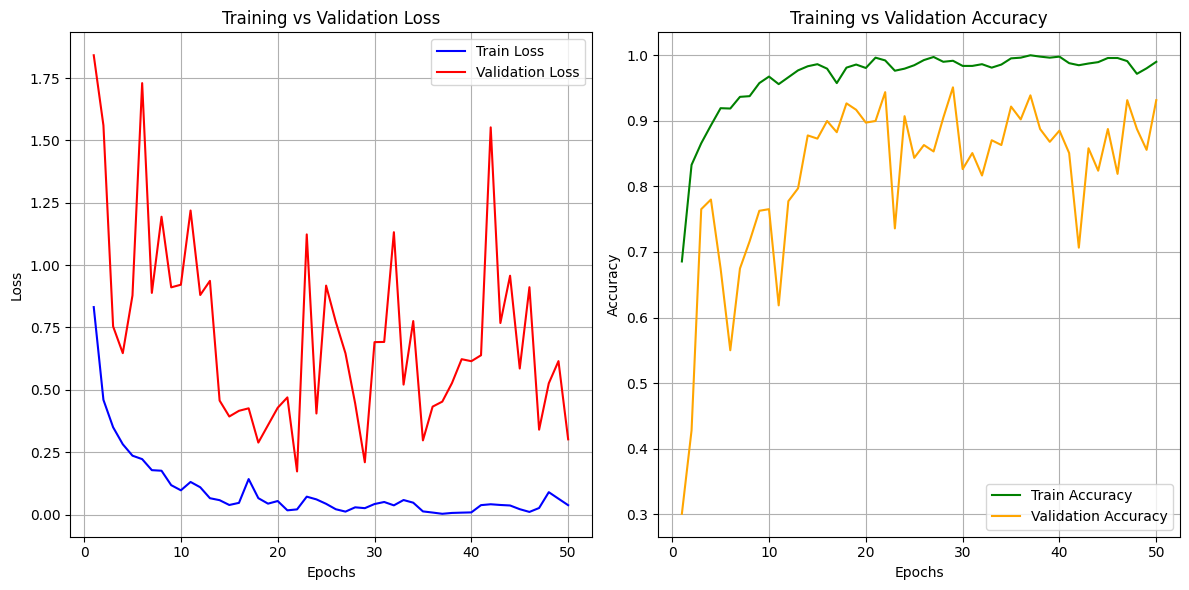

In [21]:
# -----------------------------
# Plotting Curves
# -----------------------------
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='green')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("loss_accuracy_curves.png", dpi=300)  # Optional: save figure
    plt.show()

# Plot curves
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)


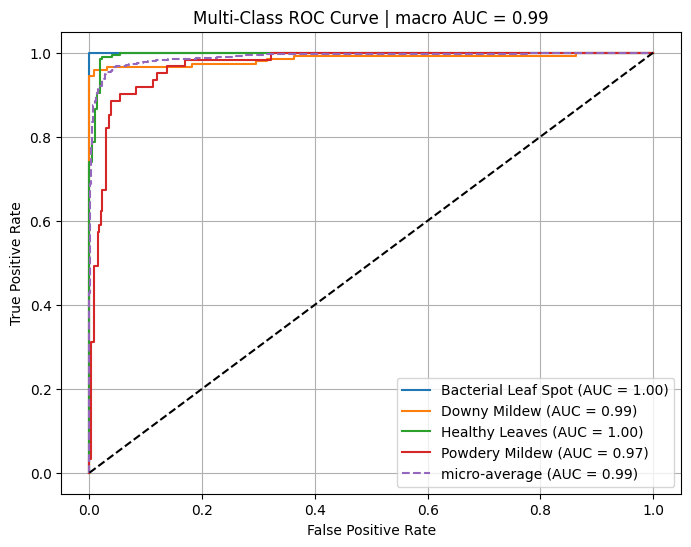

In [22]:
# ---- ROC–AUC (one-vs-rest) for multi-class ----
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.numpy())  # labels are on CPU already

# One-hot encode ground truth
y_true = label_binarize(all_labels, classes=list(range(num_classes)))  # shape: [N, C]
y_score = np.asarray(all_probs)                                        # shape: [N, C]

# Plot per-class ROC curves (skip classes missing in val set)
plt.figure(figsize=(8, 6))
plotted_any = False
for i in range(num_classes):
    # If a class is entirely missing or all-positive in y_true, roc_curve will error
    positives = y_true[:, i].sum()
    if positives == 0 or positives == y_true.shape[0]:
        # Skip to avoid ValueError; you can print a note if you want
        continue
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
    plotted_any = True

# Micro-average ROC (across all classes)
fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_score.ravel())
auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle="--", label=f"micro-average (AUC = {auc_micro:.2f})")

# Macro AUC (summary number)
try:
    auc_macro = roc_auc_score(y_true, y_score, average="macro", multi_class="ovr")
    macro_note = f" | macro AUC = {auc_macro:.2f}"
except ValueError:
    macro_note = ""

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Multi-Class ROC Curve{macro_note}")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Classification Report:

                     precision    recall  f1-score   support

Bacterial Leaf Spot       1.00      0.93      0.97        15
       Downy Mildew       1.00      0.93      0.96       145
     Healthy Leaves       0.91      1.00      0.95       188
     Powdery Mildew       0.81      0.72      0.77        61

           accuracy                           0.93       409
          macro avg       0.93      0.90      0.91       409
       weighted avg       0.93      0.93      0.93       409


Overall Accuracy: 0.93


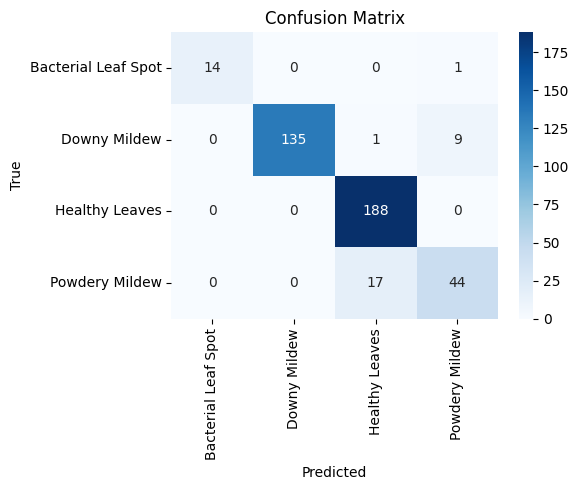

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluation on validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=2))

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nOverall Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



✅ Test Accuracy: 86.31%

📊 Classification Report:

                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.87      0.87      0.87        15
       Downy Mildew       0.95      0.86      0.90       145
     Healthy Leaves       0.85      1.00      0.92       188
     Powdery Mildew       0.66      0.44      0.53        61

           accuracy                           0.86       409
          macro avg       0.83      0.79      0.80       409
       weighted avg       0.86      0.86      0.85       409



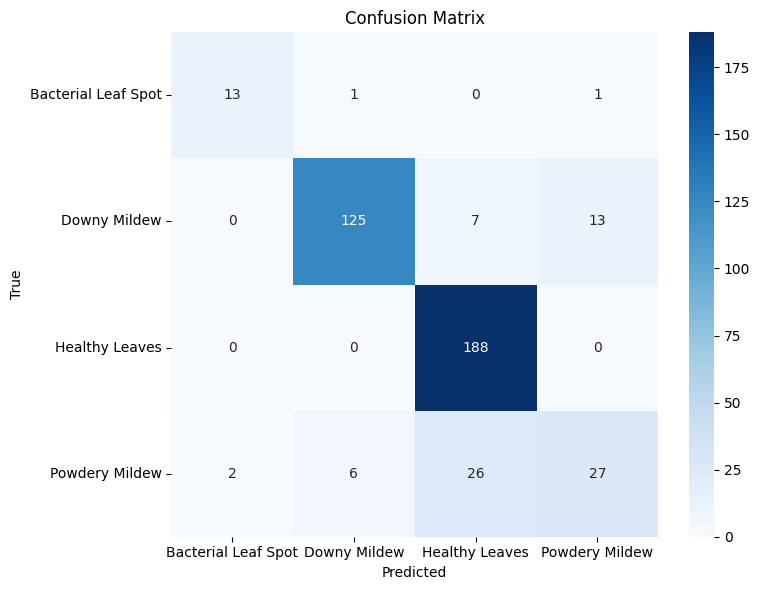

In [25]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Paths
test_dir = "/kaggle/input/detestion6/Niphad Grape Leaf Disease Dataset (NGLD)/Grapes Disease Dataset test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Dataset & Loader
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = test_dataset.classes

# Load model
encoder = BYOLResNet50(pretrained_path)  # your BYOL-pretrained encoder
model = FineTuneBYOL(encoder, num_classes=len(class_names)).to(device)
model.load_state_dict(torch.load("/kaggle/working/fine_tuned_model.pth", map_location=device))
model.eval()

# Predict
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

# Classification Report
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()